In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

from utils.common.ncmatch_config import NCMatchEvalConfig
from networks.ncmatchnet import NCMatchNet
from utils.datasets.camera_intrinsics import get_camera_intrinsic_loader
from utils.datasets.ncmatch_eval import get_test_loaders
from utils.eval.extract_ncmatches import cal_matches
from utils.eval.localize import *

# Data Loading
dataset='CambridgeLandmarks'
data_root='../data/datasets_original'
data_loaders = get_test_loaders(image_size=None, 
                                dataset=dataset, 
                                scenes=['ShopFacade'],
                                pair_txt='test_pairs.5nn.300cm50m.vlad.minmax.txt',
                                data_root=data_root, shuffle=False)

rthres = 4.0
loc_ransac_thres = 15
ncn_thres = 0.9
ckpt_dir = None #'../output/regression_models/448_normalize/nc-essnet/7scenes/checkpoint_60_0.04m_1.62deg.pth'
feat_weights =  None 
ncn_weights =  '../output/pretrained_weights/nc_ivd_5ep.pth'  
config = NCMatchEvalConfig(weights_dir=ckpt_dir, feat_weights=feat_weights,
                           ncn_weights=ncn_weights, early_feat=True)
model = NCMatchNet(config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Load testing data for immatch localization
Image size None Dataset CambridgeLandmarks Scenes ['ShopFacade'] Pairs test_pairs.5nn.300cm50m.vlad.minmax.txt
Target size 1920 Rescale size: (w=1920,h=1056) , matches resolution: 1980.0
>>>Load dataest: ['CambridgeLandmarks'] Data root: ../data/datasets_original
Dataset: CambridgeLandmarks Scene: ['ShopFacade']

Build up NC-MatchNet model...
Config: early_feat True half_precision False k_size 2
Load pretrained Resnet34 for feature extraction part and Kaiming init the left
Overwrite ncn weights...


In [6]:
num_plots = 1
with_inliers = True
k_size = 2

for scene in data_loaders:
    data_loader = data_loaders[scene]
    total_num = len(data_loader.dataset)  # Total image pair number
    base_dir = os.path.join(data_root, dataset)
    scene_dir = os.path.join(base_dir, scene)
    intrinsic_loader = get_camera_intrinsic_loader(base_dir, dataset, scene)

    # Predict essential matrix over samples
    for i, batch in enumerate(data_loader): 
        # Load essnet images
        train_im_ref, test_im_ref = batch['im_pair_refs'][0][0], batch['im_pair_refs'][1][0] 
        train_im, test_im = batch['im_pairs']
        train_im = train_im.to(model.device)
        test_im = test_im.to(model.device)

        # Calculate correspondence score map 
        with torch.no_grad():
            # Forward feature to ncn module
            if k_size>1:
                corr4d, delta4d = model.forward_corr4d(train_im, test_im)
            else:
                corr4d,delta4d=model.forward_corr4d(train_im, test_im)
                delta4d=None 

        # Calculate matches
        xA, yA, xB, yB, score = cal_matches(corr4d, delta4d, k_size=k_size,
                                            do_softmax=True,
                                            matching_both_directions=True)

        # Scale matches to original pixel level
        w, h = intrinsic_loader.w, intrinsic_loader.h
        matches = np.dstack([xA*w, yA*h, xB*w, yB*h]).squeeze() # N, 4
        K = intrinsic_loader.get_relative_intrinsic_matrix(train_im_ref, test_im_ref)
        break
    break


#         E, inliers = cv2.findEssentialMat(p1, p2, cameraMatrix=K, method=cv2.FM_RANSAC)
#         inliers = np.where(inliers.squeeze() == 1)[0]
#     plot_matches(os.path.join(gt_dir, train_im), os.path.join(gt_dir, test_im), correspondences, 
#                  Npts=100, inliers=inliers, lines=False)
#     if i >= 1:
#         break

Loading focals scene: ShopFacade cameras: 334


Find Essential Mat....Inliers: 1169
terr: [[173.07270615]] [[6.92729385]]
qerr: [[0.1712578]] [[179.88687881]]
Plot inlier matches
Plotting inliers:  500


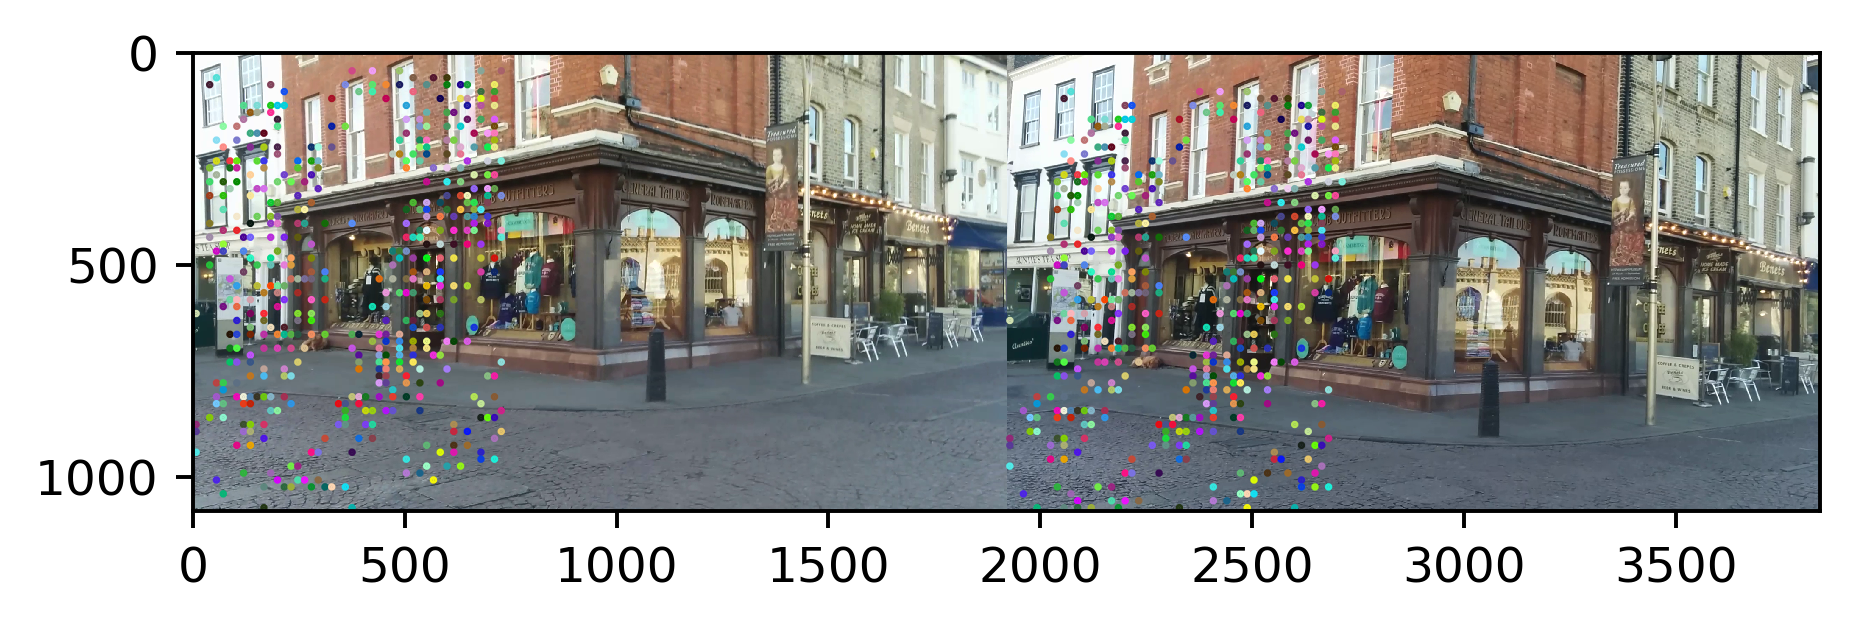

In [12]:
from transforms3d.quaternions import mat2quat
from utils.common.plotting import plot_matches
from utils.eval.measure import cal_quat_angle_error, cal_vec_angle_error
import cv2

Npts = 500
plot_top_k = False
lines = False
im_pth1 = os.path.join(scene_dir, train_im_ref) 
im_pth2 = os.path.join(scene_dir, test_im_ref)

# Scale matches to original pixel level
if plot_top_k:
    print('Plot top-k matches')
    plot_matches(im_pth1, im_pth2, matches=matches, inliers=None, Npts=Npts, lines=False)

# Find essential matrix
p1 = matches[:,:2]
p2 = matches[:,2:4]
E, inliers = cv2.findEssentialMat(p1, p2, cameraMatrix=K, method=cv2.FM_RANSAC, threshold=rthres)
(t, R0, R1) = decompose_essential_matrix(E)
print('Find Essential Mat....Inliers:', np.sum(inliers))

# Calculate relative angle errors
q0, q1 = mat2quat(R0), mat2quat(R1)
print('terr:', cal_vec_angle_error(t, batch['relv_t'].squeeze().cpu().data.numpy()), 
      cal_vec_angle_error(-t, batch['relv_t'].squeeze().cpu().data.numpy()))
print('qerr:', cal_quat_angle_error(q0, batch['relv_q'].squeeze().cpu().data.numpy()),
               cal_quat_angle_error(q1, batch['relv_q'].squeeze().cpu().data.numpy()))

# Visualize inliers
print('Plot inlier matches')
plot_matches(im_pth1, im_pth2, matches=matches, inliers=np.nonzero(inliers)[0], Npts=Npts, lines=lines)

# outliers = np.where(inliers==0)[0]
#plot_matches(src=im_pth1, tgt=im_pth2, matches=matches, inliers=outliers, Npts=None, lines=False)
